In [1]:
import io
import requests
import numpy as np
import pandas as pd
import shinybroker as sb
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

In [2]:
asset_symbols = ['AAPL', 'MSFT', 'JPM', 'XOM', 'JNJ', 'PG', 'NVDA', 'CAT', 'HD', 'AMZN']

In [3]:
def calc_trd_prd(timestamps, freq = 'M'):
    if freq == 'W':
        return [ts.isocalendar()[0] + ts.isocalendar()[1] / 100 for ts in timestamps]
    elif freq == 'M':
        return [ts.year + ts.month / 100 for ts in timestamps]

# Collecting Data

In [11]:
import os

root = os.getcwd()
data_root = os.path.join(root, 'HistoryData')

if not os.path.exists(data_root):
    os.makedirs(data_root)
    print('HistoryData directory created')
else:
    print('HistoryData folder already exists')

daily_data_dict = {}
hourly_data_dict = {}
daily_iv_dict = {}
for symbol in asset_symbols:
    print(f"\n Fetching: {symbol}")

    contract = sb.Contract({
        'symbol': symbol,
        'secType': "STK",
        'exchange': "SMART",
        'currency': "USD"
    })

    df_daily = sb.fetch_historical_data(
        contract=contract,
        barSizeSetting="1 day",
        durationStr="8 M"
    )['hst_dta']

    df_hourly = sb.fetch_historical_data(
        contract=contract,
        barSizeSetting="1 hour",
        durationStr="8 M"
    )['hst_dta']

    df_daily_iv = sb.fetch_historical_data(
        contract=contract,
        barSizeSetting="1 day",
        durationStr="10 M",
        whatToShow="OPTION_IMPLIED_VOLATILITY"
    )['hst_dta']

    df_daily['trd_prd'] = calc_trd_prd(df_daily['timestamp'])
    df_hourly['trd_prd'] = calc_trd_prd(df_hourly['timestamp'])
    df_daily_iv['trd_prd'] = calc_trd_prd(df_daily_iv['timestamp'])

    df_daily.to_csv(os.path.join(data_root, f'{symbol}_daily.csv'))
    df_daily.to_csv(os.path.join(data_root, f'{symbol}_hourly.csv'))
    df_daily.to_csv(os.path.join(data_root, f'{symbol}_iv.csv'))

    daily_data_dict[symbol] = df_daily
    hourly_data_dict[symbol] = df_hourly
    daily_iv_dict[symbol] = df_daily_iv


print(daily_data_dict)
print(hourly_data_dict)
print(daily_iv_dict)


HistoryData folder already exists

 Fetching: AAPL

 Fetching: MSFT

 Fetching: JPM

 Fetching: XOM

 Fetching: JNJ

 Fetching: PG

 Fetching: NVDA

 Fetching: CAT

 Fetching: HD

 Fetching: AMZN
{'AAPL':       timestamp    open    high     low   close    volume      wap  barCount  \
0    2024-09-03  228.55  229.00  221.17  222.77  27800491  224.005    155414   
1    2024-09-04  221.70  221.78  217.48  220.85  27586896  219.774    142977   
2    2024-09-05  221.73  225.48  221.52  222.38  21549150  223.325    115868   
3    2024-09-06  224.00  225.24  219.77  220.82  26076978  221.990    133485   
4    2024-09-09  220.83  221.27  216.71  220.91  44734345  219.098    222732   
..          ...     ...     ...     ...     ...       ...      ...       ...   
158  2025-04-22  196.00  201.59  195.97  199.74  29453698  199.095    152437   
159  2025-04-23  205.99  208.00  202.79  204.60  30480172  205.506    168370   
160  2025-04-24  204.94  208.83  202.94  208.37  21895737  206.480    12514

# 10-2Yr Yield Spread

In [12]:
YYYY = [2024, 2025]
URL_lst = ['https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=' + 'daily_treasury_yield_curve&field_tdr_date_value=' + str(year) for year in YYYY]

df_yield_curve = pd.DataFrame()
for URL in URL_lst:
    cmt_rates_page = requests.get(URL)

    soup = BeautifulSoup(cmt_rates_page.content, 'html.parser')

    table_html = soup.findAll('table', {'class': 'views-table'})

    df = pd.read_html(io.StringIO(str(table_html)))[0]
    df.Date = pd.to_datetime(df.Date)
    # usdt_3mo_cmt = df.rename(columns={'3 Mo': '3_mo'})
    df_yield_curve = pd.concat([df_yield_curve, df])

df_yield_curve = df_yield_curve[['Date', '2 Mo', '3 Mo', '4 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr']]
df_yield_curve

,Date,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,2024-01-02,5.54,5.46,5.41,5.24,4.80,4.33,4.09,3.93,3.95,3.95,4.25,4.08
1,2024-01-03,5.54,5.48,5.41,5.25,4.81,4.33,4.07,3.90,3.92,3.91,4.21,4.05
2,2024-01-04,5.48,5.48,5.41,5.25,4.85,4.38,4.14,3.97,3.99,3.99,4.30,4.13
3,2024-01-05,5.48,5.47,5.41,5.24,4.84,4.40,4.17,4.02,4.04,4.05,4.37,4.21
4,2024-01-08,5.48,5.49,5.39,5.24,4.82,4.36,4.11,3.97,3.99,4.01,4.33,4.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2025-04-22,4.35,4.33,4.33,4.21,3.98,3.76,3.82,3.98,4.19,4.41,4.90,4.88
76,2025-04-23,4.34,4.33,4.33,4.22,4.01,3.81,3.87,4.00,4.20,4.40,4.86,4.83
77,2025-04-24,4.37,4.32,4.32,4.22,3.97,3.77,3.80,3.91,4.11,4.32,4.79,4.77
78,2025-04-25,4.36,4.32,4.32,4.22,3.95,3.74,3.76,3.88,4.06,4.29,4.75,4.74


In [13]:
df_yield_spread = df_yield_curve.copy()
df_yield_spread['yield_spread'] = df_yield_spread.apply(lambda x: x['10 Yr']-x['2 Yr'], axis=1)
df_yield_spread = df_yield_spread[['Date', 'yield_spread']]
print(df_yield_spread)

         Date  yield_spread
0  2024-01-02         -0.38
1  2024-01-03         -0.42
2  2024-01-04         -0.39
3  2024-01-05         -0.35
4  2024-01-08         -0.35
..        ...           ...
75 2025-04-22          0.65
76 2025-04-23          0.59
77 2025-04-24          0.55
78 2025-04-25          0.55
79 2025-04-28          0.56

[330 rows x 2 columns]


# Calculate Indicators and Scores

In [36]:
def calculate_ema(prices, period=20):
    return prices.ewm(span=period, adjust=False).mean()


def calculate_macd(prices, fast=12, slow=26, signal=9):
    ema_fast = prices.ewm(span=fast, adjust=False).mean()
    ema_slow = prices.ewm(span=slow, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal, adjust=False).mean()
    macd_diff = macd_line - signal_line
    return macd_diff


def calculate_adx(high, low, close, period=14):
    # Calculate True Range
    tr1 = abs(high - low)
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=period).mean()

    # Calculate Plus Directional Movement (+DM) and Minus Directional Movement (-DM)
    plus_dm = high - high.shift(1)
    minus_dm = low.shift(1) - low
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm < 0] = 0

    # Condition when both +DM and -DM are greater than 0
    condition = (plus_dm > 0) & (minus_dm > 0)
    plus_dm[condition & (plus_dm < minus_dm)] = 0
    minus_dm[condition & (minus_dm < plus_dm)] = 0

    # Calculate Smoothed +DM and -DM
    smoothed_plus_dm = plus_dm.rolling(window=period).sum()
    smoothed_minus_dm = minus_dm.rolling(window=period).sum()

    # Calculate Smoothed TR
    smoothed_tr = atr * period

    # Calculate Plus Directional Indicator (+DI) and Minus Directional Indicator (-DI)
    plus_di = 100 * (smoothed_plus_dm / smoothed_tr)
    minus_di = 100 * (smoothed_minus_dm / smoothed_tr)

    # Calculate Directional Movement Index (DX)
    dx = 100 * (abs(plus_di - minus_di) / (plus_di + minus_di))

    # Calculate Average Directional Index (ADX)
    adx = dx.rolling(window=period).mean()

    return adx


def calculate_atr(high, low, close, period=14):
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=period).mean()
    return atr


def calculate_iv_percentile(iv_series):
    percentile = (iv_series.rank(pct=True) * 100).iloc[-1]
    return percentile


def calculate_ema_score(price, ema20):
    delta = 100 * (price - ema20) / ema20

    # Calculate scores based on delta
    long_score = 0
    short_score = 0

    # Long score calculation
    if delta < -5:
        long_score = 5
    elif -5 <= delta < -3:
        long_score = 4
    elif -3 <= delta < -1:
        long_score = 3
    elif -1 <= delta < 0:
        long_score = 2

    # Short score calculation
    if delta > 5:
        short_score = 5
    elif 3 < delta <= 5:
        short_score = 4
    elif 1 < delta <= 3:
        short_score = 3
    elif 0 < delta <= 1:
        short_score = 2

    return long_score, short_score


def calculate_macd_score(macd_diff):
    long_score = 0
    short_score = 0

    # Long score calculation
    if macd_diff < -1.5:
        long_score = 5
    elif -1.5 <= macd_diff < -1:
        long_score = 4
    elif -1 <= macd_diff < -0.5:
        long_score = 3
    elif -0.5 <= macd_diff < -0.1:
        long_score = 2
    elif -0.1 <= macd_diff < 0:
        long_score = 1

    # Short score calculation
    if macd_diff > 1.5:
        short_score = 5
    elif 1 <= macd_diff <= 1.5:
        short_score = 4
    elif 0.5 <= macd_diff < 1:
        short_score = 3
    elif 0.1 <= macd_diff < 0.5:
        short_score = 2
    elif 0 <= macd_diff < 0.1:
        short_score = 1

    return long_score, short_score


def calculate_adx_score(adx):
    if adx <= 15:
        return 0
    elif 15 < adx <= 20:
        return 2
    elif 20 < adx <= 30:
        return 5
    elif 30 < adx <= 40:
        return 2
    else:  # adx > 40
        return 0


def calculate_atr_score(atr):
    if atr > 30:
        return 0
    elif 20 < atr <= 30:
        return 2
    elif 10 < atr <= 20:
        return 5
    elif 5 < atr <= 10:
        return 4
    else:  # atr < 5
        return 2


def calculate_iv_score(iv_percentile):
    long_score = 0
    short_score = 0

    if iv_percentile < 10:
        long_score = 5
        short_score = 0
    elif 10 <= iv_percentile < 30:
        long_score = 4
        short_score = 1
    elif 30 <= iv_percentile < 70:
        long_score = 2
        short_score = 2
    elif 70 <= iv_percentile < 90:
        long_score = 1
        short_score = 4
    else:  # iv_percentile >= 90
        long_score = 0
        short_score = 5

    return long_score, short_score


def calculate_yield_spread_score(yield_spread):
    long_score = 0
    short_score = 0

    if yield_spread > 1.5:
        long_score = 5
        short_score = 0
    elif 0.5 < yield_spread <= 1.5:
        long_score = 4
        short_score = 1
    elif -0.5 <= yield_spread <= 0.5:
        long_score = 2
        short_score = 2
    elif -1.5 <= yield_spread < -0.5:
        long_score = 1
        short_score = 4
    else:  # yield_spread < -1.5
        long_score = 0
        short_score = 5

    return long_score, short_score


def calculate_total_score(ema_long, ema_short, macd_long, macd_short, adx, atr, iv_long, iv_short, yield_long, yield_short):
    long_score = .25 * ema_long + .25 * macd_long + .1 * adx + .1 * atr + .15 * iv_long + .15 * yield_long
    short_score = .25 * ema_short + .25 * macd_short + .1 * adx + .1 * atr + .15 * iv_short + .15 * yield_short

    if long_score > short_score:
        return long_score, 'LONG'
    else:
        return -1*short_score, 'SHORT'

# Visualization

In [15]:
def plot_performance(ledger):
    plt.figure(figsize=(14, 7))
    plt.plot(ledger.index, ledger['Market Value'], label='End of Day Portfolio Market Value')
    plt.title('End of Day Portfolio Market Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value ($)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Backtest Strategy Function

In [29]:
def backtest_strategy(daily_data_dict, hourly_data_dict, daily_iv_dict, df_yield_spread, asset_symbols, initial_capital=1000000):
    # Ensure timestamps in df_yield_spread are in datetime format
    df_yield_spread['Date'] = pd.to_datetime(df_yield_spread['Date'])

    # Create asset blotters
    asset_blotter_dict = {}
    for asset in asset_symbols:
        blotter = pd.DataFrame(
            data={
                'entry_timestamp': None,
                'qty': 0,
                'exit_timestamp': None,
                'entry_price': None,
                'exit_price': None,
                'success': pd.NA
            },
            index=daily_data_dict[asset]['trd_prd'].unique()[2:]
        )
        asset_blotter_dict[asset] = blotter

    # Create portfolio blotter for rebalancing weights
    portfolio_periods = daily_data_dict[asset_symbols[0]]['trd_prd'].unique()[2:]
    print(f"backtest periods: {portfolio_periods}")
    portfolio_blotter = pd.DataFrame(index=portfolio_periods, columns=asset_symbols)
    portfolio_blotter.index.name = 'trd_prd'

    # Get all unique dates from the daily data for the ledger
    all_dates = []
    for asset in asset_symbols:
        # Ensure timestamp column is datetime
        daily_data_dict[asset]['timestamp'] = pd.to_datetime(daily_data_dict[asset]['timestamp'])
        # Extract dates
        portfolio_dates = daily_data_dict[asset][daily_data_dict[asset]['trd_prd']>=portfolio_periods[0]]['timestamp']
        all_dates.extend(portfolio_dates.dt.date.tolist())
    all_dates = sorted(list(set(all_dates)))

    # Create portfolio ledger with date index
    ledger_columns = ['Cash']
    for asset in asset_symbols:
        ledger_columns.append(f"{asset} Qty")
    for asset in asset_symbols:
        ledger_columns.append(f"{asset} Price")
    ledger_columns.extend(['Portfolio Value', 'Market Value'])

    ledger = pd.DataFrame(index=all_dates, columns=ledger_columns)
    ledger.index.name = 'Date'
    ledger['Cash'] = np.nan
    ledger.loc[min(all_dates), 'Cash'] = initial_capital
    for asset in asset_symbols:
        ledger[f"{asset} Qty"] = 0

    # Fill initial prices in ledger
    for date in all_dates:
        for asset in asset_symbols:
            mask = daily_data_dict[asset]['timestamp'].dt.date == date
            if mask.any():
                price_row = daily_data_dict[asset][mask]
                if not price_row.empty:
                    ledger.loc[date, f"{asset} Price"] = price_row['close'].values[0]

    # Process each trading period
    for period_idx, period in enumerate(portfolio_periods):
        # Get previous period for calculations
        prev_period = daily_data_dict[asset_symbols[0]]['trd_prd'].unique()[period_idx+1]
        prev_2_period = daily_data_dict[asset_symbols[0]]['trd_prd'].unique()[period_idx]
        # print(f"Processing period: {period:.2f} Previous period: {prev_period:.2f}, Previous 2 period: {prev_2_period:.2f}")

        # Calculate indicators and weights for each asset
        asset_scores = {}
        total_score = 0

        for asset in asset_symbols:
            # Get data for previous period
            prev_data = daily_data_dict[asset][daily_data_dict[asset]['trd_prd'] <= prev_period]
            last_data = daily_data_dict[asset][daily_data_dict[asset]['trd_prd'] == prev_period]
            vol = last_data['close'].std()/100

            if prev_data.empty:
                continue

            # Calculate indicators
            last_close = prev_data['close'].iloc[-1]

            # EMA indicator
            ema20 = calculate_ema(prev_data['close'], 20).iloc[-1]
            ema_long, ema_short = calculate_ema_score(last_close, ema20)

            # MACD indicator
            macd_diff = calculate_macd(prev_data['close'], fast = 11, slow = 44, signal = 22).iloc[-1]
            macd_long, macd_short = calculate_macd_score(macd_diff)

            # ADX indicator
            adx = calculate_adx(prev_data['high'], prev_data['low'], prev_data['close'], period = 11).iloc[-1]
            adx_score = calculate_adx_score(adx)

            # ATR indicator
            atr = calculate_atr(prev_data['high'], prev_data['low'], prev_data['close'], period = 11).iloc[-1]
            atr_score = calculate_atr_score(atr)

            # IV indicator
            iv_window = daily_iv_dict[asset][
                (daily_iv_dict[asset]['trd_prd'] >= prev_2_period) &
                (daily_iv_dict[asset]['trd_prd'] <= period)
            ]['close'].dropna()


            iv_percentile = calculate_iv_percentile(iv_window)
            iv_long, iv_short = calculate_iv_score(iv_percentile)

            # Yield spread indicator
            # Use timestamp directly for comparison with datetime Series
            last_timestamp = prev_data['timestamp'].iloc[-1]
            yield_date_mask = df_yield_spread['Date'] <= last_timestamp

            if yield_date_mask.any():
                last_yield_date = df_yield_spread.loc[yield_date_mask, 'Date'].iloc[-1]
                yield_spread = df_yield_spread[df_yield_spread['Date'] == last_yield_date]['yield_spread'].values[0]
                yield_long, yield_short = calculate_yield_spread_score(yield_spread)
            else:
                yield_long, yield_short = 0, 0

            # Calculate total score and direction
            score, direction = calculate_total_score(
                ema_long, ema_short, macd_long, macd_short, adx_score, atr_score,
                iv_long, iv_short, yield_long, yield_short
            )
            # print(f"period: {period} {asset} score: {score}, direction: {direction}")

            # Store score, direction and ATR for stop loss/take profit
            asset_scores[asset] = {
                'score': score,
                'direction': direction,
                'atr': atr
            }

            total_score += score

        # Calculate weights
        weights = {}
        for asset in asset_scores:
            weight = asset_scores[asset]['score'] / abs(total_score)

            weights[asset] = weight

            # Update portfolio blotter
            portfolio_blotter.loc[period, asset] = weight

        # Get first trading day of the period for each asset
        for asset in asset_symbols:
            if asset not in weights or asset not in asset_scores:
                continue

            # Get first trading day of the period
            period_data = daily_data_dict[asset][daily_data_dict[asset]['trd_prd'] == period]
            if period_data.empty:
                continue

            entry_timestamp = period_data['timestamp'].iloc[0]
            entry_date = entry_timestamp.date()
            entry_price = period_data['open'].iloc[0]

            # Get current portfolio value
            mask = [d <= entry_date for d in ledger.index]
            if any(mask):
                last_market_value = ledger.loc[mask, 'Market Value'].iloc[-1]
                # print(last_market_value)
                if pd.isna(last_market_value):
                    # Use initial capital if no market value available yet
                    last_market_value = initial_capital
            else:
                last_market_value = initial_capital

            # Calculate target position
            target_value = weights[asset] * last_market_value
            target_qty = int(target_value / entry_price)

            # Update asset blotter
            asset_blotter_dict[asset].loc[period, 'entry_timestamp'] = entry_timestamp
            asset_blotter_dict[asset].loc[period, 'entry_price'] = entry_price
            asset_blotter_dict[asset].loc[period, 'qty'] = target_qty

            ledger_dates_entry = [d for d in ledger.index if d >= entry_date]
            for d in ledger_dates_entry:
                ledger.loc[d, f"{asset} Qty"] = target_qty

            prev_cash = ledger['Cash'].ffill().loc[entry_date]
            ledger.loc[entry_date, 'Cash'] = prev_cash - target_qty * entry_price


            # Process stop loss/take profit for this asset
            # Ensure hourly data timestamp is datetime
            hourly_data_dict[asset]['timestamp'] = pd.to_datetime(hourly_data_dict[asset]['timestamp'])
            period_hourly_data = hourly_data_dict[asset][hourly_data_dict[asset]['trd_prd'] == period]

            direction = asset_scores[asset]['direction']
            atr = asset_scores[asset]['atr']

            # Define stop loss/take profit levels
            if direction == 'LONG':
                stop_loss_level = entry_price * (1- .5 * vol)
                take_profit_level = entry_price * (1 + .5 * vol)
            else:  # SHORT
                stop_loss_level = entry_price * (1 + .5 * vol)
                take_profit_level = entry_price* (1 - .5 * vol)

            # Check for stop loss/take profit triggers
            exit_triggered = False
            exit_timestamp = None
            exit_price = None

            for _, row in period_hourly_data.iterrows():
                if direction == 'LONG':
                    # Check for take profit
                    if row['close'] >= take_profit_level:
                        exit_triggered = True
                        exit_timestamp = row['timestamp']
                        exit_price = row['close']
                        break
                    # Check for stop loss
                    elif row['close'] <= stop_loss_level:
                        exit_triggered = True
                        exit_timestamp = row['timestamp']
                        exit_price = row['close']
                        break
                else:  # SHORT
                    # Check for take profit
                    if row['close'] <= take_profit_level:
                        exit_triggered = True
                        exit_timestamp = row['timestamp']
                        exit_price = row['close']
                        break
                    # Check for stop loss
                    elif row['close'] >= stop_loss_level:
                        exit_triggered = True
                        exit_timestamp = row['timestamp']
                        exit_price = row['close']
                        break

            # If no exit triggered, use the last day of the period
            if not exit_triggered and not period_data.empty:
                exit_timestamp = period_data['timestamp'].iloc[-1]
                exit_price = period_data['close'].iloc[-1]

            # Update asset blotter with exit information
            if exit_timestamp is not None and exit_price is not None:
                asset_blotter_dict[asset].loc[period, 'exit_timestamp'] = exit_timestamp
                asset_blotter_dict[asset].loc[period, 'exit_price'] = exit_price

                # Determine if trade was successful
                if direction == 'LONG':
                    success = exit_price > entry_price
                else:  # SHORT
                    success = exit_price < entry_price
                asset_blotter_dict[asset].loc[period, 'success'] = success

                # Update ledger for exit
                exit_date = exit_timestamp.date()

                # 对所有后续日期更新持仓数量为0
                ledger_dates_exit = [d for d in ledger.index if d >= exit_date]
                for d in ledger_dates_exit:
                    ledger.loc[d, f"{asset} Qty"] = 0

                current = ledger.loc[exit_date, 'Cash']
                if pd.isna(current):
                    current = ledger['Cash'].ffill().loc[exit_date]
                ledger.loc[exit_date, 'Cash'] = current + target_qty * exit_price
        ledger = ledger.ffill()

    ledger['Cash'] = ledger['Cash'].ffill()

    for date in ledger.index:
        portfolio_value = 0
        for asset in asset_symbols:
            qty = ledger.loc[date, f"{asset} Qty"]
            price = ledger.loc[date, f"{asset} Price"]
            if not pd.isna(qty) and not pd.isna(price):
                portfolio_value += qty * price

        ledger.loc[date, 'Portfolio Value'] = portfolio_value
        ledger.loc[date, 'Market Value'] = ledger.loc[date, 'Cash'] + portfolio_value

    ledger = ledger.ffill()

    return asset_blotter_dict, portfolio_blotter, ledger

# Implement Startegy

backtest periods: [2024.11 2024.12 2025.01 2025.02 2025.03 2025.04]


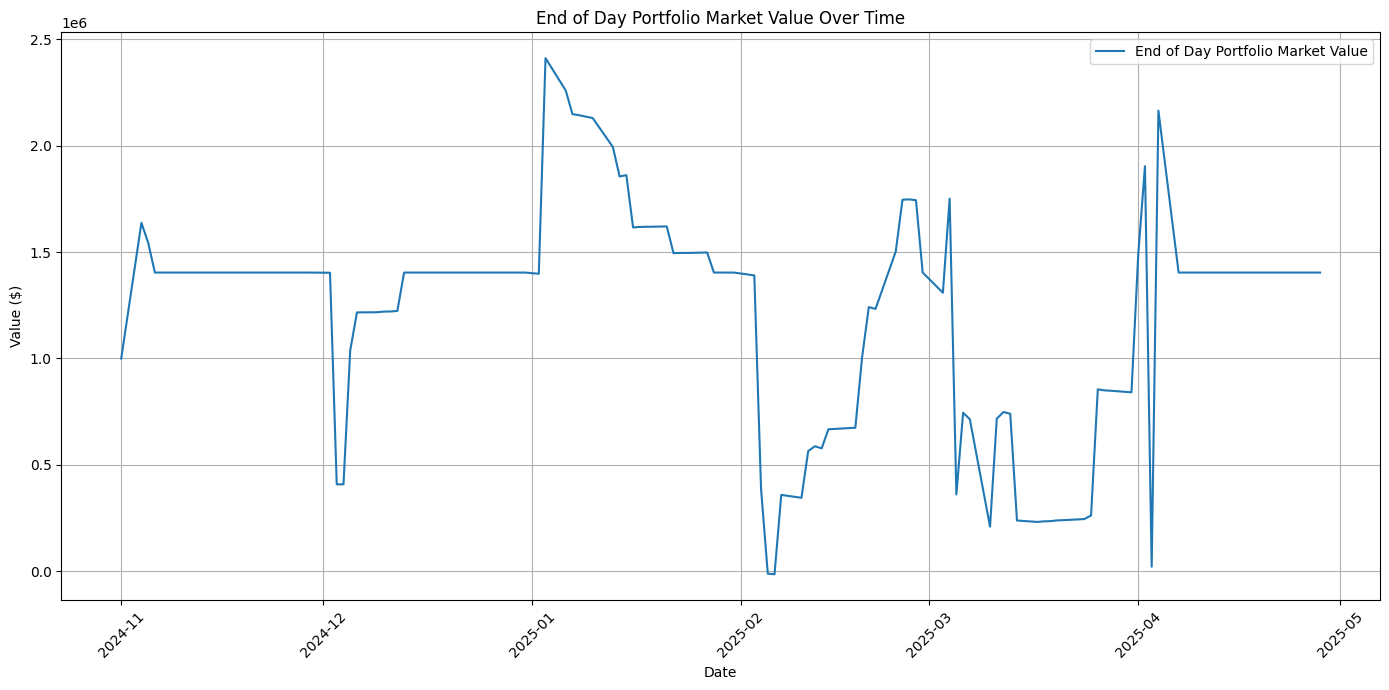


Portfolio Blotter (Target Weights):
             AAPL      MSFT       JPM       XOM       JNJ        PG      NVDA  \
trd_prd                                                                         
2024.11  0.106719  0.124506 -0.088933  0.118577  0.098814   0.13834  0.098814   
2024.12 -0.186246 -0.140401 -0.191977  0.143266 -0.106017 -0.200573  0.183381   
2025.01 -0.126949  0.144766  0.113586  0.124722  0.091314  0.113586  0.142539   
2025.02  0.239583  0.354167 -0.348958 -0.213542   -0.3125 -0.239583  0.385417   
2025.03 -0.522936   0.53211  0.477064 -0.422018 -0.559633 -0.633028  0.550459   

              CAT        HD      AMZN  
trd_prd                                
2024.11  0.156126  0.144269  0.102767  
2024.12 -0.186246 -0.186246  -0.12894  
2025.01  0.144766  0.131403  0.120267  
2025.02 -0.244792 -0.286458 -0.333333  
2025.03  0.495413  0.541284  0.541284  

Sample Asset Blotter (AAPL):
             entry_timestamp   qty       exit_timestamp entry_price  \
2024.11  2024-

In [37]:
# Main execution
import warnings
warnings.filterwarnings('ignore')
asset_blotter_dict, portfolio_blotter, ledger = backtest_strategy(
    daily_data_dict, hourly_data_dict, daily_iv_dict, df_yield_spread, asset_symbols
)

# Plot performance
plot_performance(ledger)

# Print summary
print("\nPortfolio Blotter (Target Weights):")
print(portfolio_blotter.head())

print("\nSample Asset Blotter (AAPL):")
print(asset_blotter_dict['AAPL'].head())

print("\nLedger Sample:")
print(ledger.head())

print("\nFinal Portfolio Value:", ledger['Market Value'].iloc[-1])

portfolio_blotter.to_csv('blotter.csv')
ledger.to_csv('ledger.csv')

In [39]:
portfolio_blotter
# portfolio_blotter.sum(axis=1)

,AAPL,MSFT,JPM,XOM,JNJ,PG,NVDA,CAT,HD,AMZN
trd_prd,,,,,,,,,,
2024.11,0.106719,0.124506,-0.088933,0.118577,0.098814,0.13834,0.098814,0.156126,0.144269,0.102767
2024.12,-0.186246,-0.140401,-0.191977,0.143266,-0.106017,-0.200573,0.183381,-0.186246,-0.186246,-0.12894
2025.01,-0.126949,0.144766,0.113586,0.124722,0.091314,0.113586,0.142539,0.144766,0.131403,0.120267
2025.02,0.239583,0.354167,-0.348958,-0.213542,-0.3125,-0.239583,0.385417,-0.244792,-0.286458,-0.333333
2025.03,-0.522936,0.53211,0.477064,-0.422018,-0.559633,-0.633028,0.550459,0.495413,0.541284,0.541284
2025.04,0.847458,0.79661,-0.508475,-1.033898,-0.694915,0.779661,1.118644,-0.847458,-0.677966,1.220339


In [40]:
ledger

,Cash,AAPL Qty,MSFT Qty,JPM Qty,XOM Qty,JNJ Qty,PG Qty,NVDA Qty,CAT Qty,HD Qty,...,JPM Price,XOM Price,JNJ Price,PG Price,NVDA Price,CAT Price,HD Price,AMZN Price,Portfolio Value,Market Value
Date,,,,,,,,,,,,,,,,,,,,,
2024-11-01,217620.41,482,304,-397,0,615,836,0,412,365,...,222.94,114.95,160.13,165.10,135.40,379.63,392.59,197.93,782026.26,999646.67
2024-11-04,968506.40,482,304,0,0,0,836,0,412,365,...,219.78,118.61,158.24,165.08,136.05,376.52,395.57,195.78,668696.83,1637203.23
2024-11-05,1026309.84,482,304,0,0,0,836,0,0,365,...,221.49,118.96,158.35,165.76,139.91,383.37,400.09,199.50,517394.95,1543704.79
2024-11-06,1403432.06,0,0,0,0,0,0,0,0,0,...,247.06,121.00,157.88,161.05,145.61,416.88,388.37,207.09,0.00,1403432.06
2024-11-07,1403432.06,0,0,0,0,0,0,0,0,0,...,236.38,121.15,156.73,163.41,148.88,408.21,399.44,210.05,0.00,1403432.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-22,1403432.06,0,0,0,0,0,0,0,0,0,...,235.59,108.30,157.75,167.88,98.89,291.17,354.43,173.18,0.00,1403432.06
2025-04-23,1403432.06,0,0,0,0,0,0,0,0,0,...,240.88,107.37,155.38,165.73,102.71,295.77,356.42,180.60,0.00,1403432.06
2025-04-24,1403432.06,0,0,0,0,0,0,0,0,0,...,244.64,108.63,154.93,159.53,106.43,306.86,359.64,186.54,0.00,1403432.06
